<a href="https://colab.research.google.com/github/lmerchant/scrippsco2_notebooks/blob/main/notebooks/plot_full_mlo_record.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Plot full record of Mauna Loa in-situ data

In [1]:
%matplotlib inline
import ssl
import pandas as pd
import numpy as np
import pathlib
from datetime import datetime, date
from pathlib import Path
from google.colab import files
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import ticker
from matplotlib import rc,rcParams
from matplotlib import animation
import IPython
from IPython.display import Javascript, display
from IPython.utils import io
from ipywidgets import widgets
import certifi
from IPython.display import HTML
from base64 import b64encode

### Set directories and file names for data and plot

In [9]:
insitu_data_dir = 'https://scrippsco2.ucsd.edu/assets/data/atmospheric/stations/in_situ_co2/monthly'

monthly_mlo_file = 'monthly_in_situ_co2_mlo.csv'
data_url = f"{insitu_data_dir}/{monthly_mlo_file}" 

plot_dir = pathlib.Path('./plots')
plot_dir.mkdir(exist_ok=True)

pdf_file = plot_dir / 'mlo_record.pdf'
png_file = plot_dir / 'mlo_record.png'

# Load in Data and process

### Import data using Pandas

In [12]:
# https://scrippsco2.ucsd.edu gives invalid SSL certificate
# This is fix to get around that
ssl._create_default_https_context = ssl._create_unverified_context

# Then can get data with pandas through url
df = pd.read_csv(data_url, comment='"', skipinitialspace=True)
df.head()

,Yr,Mn,Date,Date.1,CO2,seasonally,fit,seasonally.1,CO2.1,seasonally.2
0,NaN,NaN,NaN,NaN,NaN,adjusted,NaN,adjusted fit,filled,adjusted filled
1,NaN,NaN,Excel,NaN,[ppm],[ppm],[ppm],[ppm],[ppm],[ppm]
2,1958.0,1.0,21200,1958.0411,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99
3,1958.0,2.0,21231,1958.1260,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99
4,1958.0,3.0,21259,1958.2027,315.71,314.43,316.20,314.91,315.71,314.43


### Remove next two rows containing header information and change to numeric vals

In [13]:
# There are 3 header lines and will skip the 2nd and 3rd along with renaming the first header line cols
# Since read in strings from the extra header lines, convert columns back to numeric values
df = df.iloc[2:]
df = df.apply(pd.to_numeric)

### Rename column names to replace duplicate names

In [ ]:
col_mapping ={df.columns[0]:'year', df.columns[1]: 'month', df.columns[2]: 'excel_date', 
              df.columns[3]: 'dec_date', df.columns[4]: 'co2', df.columns[5]: 'co2_seasonal',
              df.columns[6]: 'co2_fit', df.columns[7]: 'co2_seasonal_fit', 
              df.columns[8]:'co2_filled', df.columns[9]: 'co2_seasonal_filled'}
df = df.rename(columns=col_mapping)
df.head()

,year,month,excel_date,dec_date,co2,co2_seasonal,co2_fit,co2_seasonal_fit,co2_filled,co2_seasonal_filled
2,1958,1,21200,1958.0411,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99
3,1958,2,21231,1958.1260,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99
4,1958,3,21259,1958.2027,315.71,314.44,316.20,314.91,315.71,314.44
5,1958,4,21290,1958.2877,317.45,315.16,317.30,314.99,317.45,315.16
6,1958,5,21320,1958.3699,317.51,314.71,317.87,315.07,317.51,314.71


### Break into 2 dataframes. One for CO2 and one for the CO2 spline
The decimal date is the midpoint of each month

In [ ]:
df_co2 = df[['dec_date', 'co2']].copy()
df_co2_spline = df[['dec_date', 'co2_fit']].copy()

### Remove CO2 rows and CO2 spline rows with fill values -99.99

In [ ]:
df_co2 = df_co2[df_co2['co2'] != -99.99]
df_co2_spline = df_co2_spline[df_co2_spline['co2_fit'] != -99.99]

### Convert to numpy arrays for plotting

In [ ]:
date_co2 = df_co2['dec_date'].to_numpy()
co2 = df_co2['co2'].to_numpy()
date_co2_spline = df_co2_spline['dec_date'].to_numpy()
co2_spline = df_co2_spline['co2_fit'].to_numpy()

# Plotting functions

### Get todays date

In [ ]:
def get_todays_date():

    # Get variations of todays date

    def dt_to_dec(dt):
        """Convert a datetime to decimal year."""
        year_start = datetime(dt.year, 1, 1)
        year_end = year_start.replace(year=dt.year+1)
        return dt.year + (dt - year_start) / (year_end - year_start)

    today = date.today()
    today_with_time = datetime(
        year=today.year, month=today.month, day=today.day)

    today_decimal = dt_to_dec(today_with_time)

    todays_day = today.day
    todays_month = today.strftime("%B")
    todays_year = today.year
    todays_date_moyr = today.strftime("%B %Y")
    todays_date_modyyr = f"{todays_month} {todays_day}, {todays_year}"

    return todays_date_moyr, todays_date_modyyr, today_decimal, todays_year

### Get archive date from file

In [ ]:
def get_file_archive_date(data_file):

    # Sample archive line from file
    # " Baseline data in this file through 01-Jul-2021 from archive dated 02-Jul-2021 09:04:47    "

    pattern_archive = re.compile("archive")
    pattern_archive_date = re.compile(r'archive dated (\d\d-\w{3}-\d\d\d\d)')

    for line in open(data_file):
        for match in re.finditer(pattern_archive, line):
            m = pattern_archive_date.search(line)
            archive_date = m.group(1)
            archive_datetime = datetime.strptime(archive_date, '%d-%b-%Y')
            # Reformat to Month name Month day, Month year
            month = archive_datetime.strftime("%B")
            archive_date = f"{month} {archive_datetime.day}, {archive_datetime.year}"
            break

    return archive_date

### Set plot titles

In [ ]:
def add_3_plot_titles(fig, ax, title1, title2, title3):

    # Allow room at top for the 3 titles
    fig.subplots_adjust(top=0.85)

    # Set font properties
    rcParams.update({
      'font.family':'sans-serif',
      'font.weight':'bold',
      'font.sans-serif':['Liberation Sans', 'DejaVu Sans']
    })

    # position titles above plot
    ax.annotate(title1, xy=(0, 1.15), xycoords='axes fraction', fontsize=21,
                horizontalalignment='left', verticalalignment='top')
    ax.annotate(title2, xy=(0, 1.095), xycoords='axes fraction', fontsize=21,
                horizontalalignment='left', verticalalignment='top')
    ax.annotate(title3, xy=(0, 1.04), xycoords='axes fraction', fontsize=12, fontweight='normal',
                horizontalalignment='left', verticalalignment='top')

### Set plot ticks and axis properties

In [ ]:
def set_axis_tick_props(fig, ax, xmin, xmax, ymin, ymax):

    # activate latex text rendering
    rc('axes', linewidth=1)

    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    
    # Set tick labels font
    rcParams.update({
      'font.family':'sans-serif',
      'font.weight':'bold',
      'font.sans-serif':['Liberation Sans', 'DejaVu Sans']
    })
        
    ax.tick_params(which='both', bottom=True, top=True, left=True, right=True)

    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=16)

    ax.tick_params(which='major', direction='in', length=9, width=1)

    xaxis_tick_spacing = 5
    ax.xaxis.set_major_locator(ticker.MultipleLocator(xaxis_tick_spacing))

    yaxis_tick_spacing = 5
    ax.yaxis.set_major_locator(ticker.MultipleLocator(yaxis_tick_spacing))

    # Display every other y major tick label
    for label in ax.yaxis.get_ticklabels()[::2]:
        label.set_visible(False)

    ax.tick_params(which='minor', direction='in', length=4)
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(5))
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(5))

### Get SIO logo

In [ ]:
def add_sio_logo(fig):

    # Get logo from Github repo
    
    # Suppress output from curl
    with io.capture_output() as captured:
        !curl -O https://raw.githubusercontent.com/lmerchant/scrippsco2_notebooks/main/images/sio_logo.png

    img_file = '/content/sio_logo.png'

    logo = mpimg.imread(img_file)

    newax = fig.add_axes([0.73, 0.18, 0.2, 0.2], anchor='SE', zorder=1)

    plt.imshow(logo)

    plt.axis('off')


### Save plot

In [ ]:
def save_plot_pdf_png(fig, pdf_file, png_file):

    # Save plot as  pdf and png for scrippsco2 website

    # For pdf
    width_in = 11
    height_in = 8.5
    fig.set_size_inches(width_in, height_in)

    plt.subplots_adjust(left=0.109, right=0.95, top=0.85, bottom=0.15)

    fig.savefig(pdf_file, facecolor='w', edgecolor='w',
                orientation='landscape', format=None,
                transparent=False, pad_inches=0)

    # For png
    width_px = 1200
    height_px = (height_in/width_in) * width_px

    png_dpi = 100
    fig.set_size_inches(width_px/png_dpi, height_px/png_dpi)

    fig.savefig(png_file, facecolor='w', edgecolor='w',
                orientation='landscape', dpi=png_dpi, pad_inches=0)

# Create Plot

### Get todays date

In [ ]:
todays_date_moyr, todays_date_modyyr, today_decimal, todays_year = get_todays_date()

### Set plot limits

In [ ]:
xmin = 1957
xmax = todays_year + 2

ymin = 310
ymax = 425

### Set plot labels and titles

In [ ]:
xlabel = 'Year'
ylabel = '$\mathregular{CO_2}$ Concentration (ppm)'

title1 = 'Mauna Loa Observatory, Hawaii'
title2 = 'Monthly Average Carbon Dioxide Concentration'
title3 = f'Data from Scripps CO$_2$ Program     Last updated {todays_date_moyr}'

## Plot data and run plotting functions to modify plot

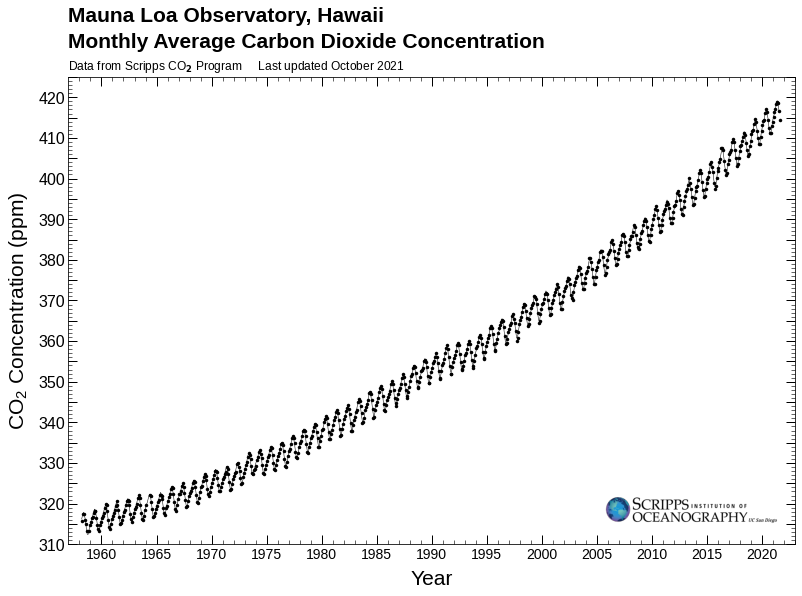

In [ ]:
# ---------
# Plot data
# ---------

fig = plt.figure()
ax = fig.add_subplot()

ax.plot(date_co2, co2, 'o', color='black',
         markersize=3.5, linewidth=1,
         markerfacecolor='black', markeredgecolor='black', markeredgewidth=0)

ax.plot(date_co2_spline, co2_spline, '-', color='black', linewidth=0.5)

# -------------------
# Set plot properties
# -------------------
set_axis_tick_props(fig, ax, xmin, xmax, ymin, ymax)

# ---------------
# Add plot titles
# ---------------
add_3_plot_titles(fig, ax, title1, title2, title3)

# ---------------
# Add axis labels
# ---------------
ax.set_xlabel(xlabel, fontsize=21, fontweight=400, labelpad=8)
ax.set_ylabel(ylabel, fontsize=21, fontweight=400, labelpad=8)

# --------------------
# Add SIO logo to plot
# --------------------
add_sio_logo(fig)

# ---------------------
# Save plot for website
# ---------------------
fig = plt.gcf()

save_plot_pdf_png(fig, pdf_file, png_file)

plt.show()

## Download Plots (pdf & png)

In [ ]:
def download_files(ev):
    #display(Javascript('IPython.notebook.execute_cells_below()'))
    files.download(pdf_file)

button = widgets.Button(description='Download Files', button_style='primary')
button.on_click(download_files)
display(button)

Button(button_style='primary', description='Download Files', style=ButtonStyle())

# Create animation of the plot


In [ ]:
# First set up the figure, the axis, and the plot element we want to animate
fig,ax = plt.subplots(1, 1, figsize = (10, 6))

ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

#ax = plt.axes(xlim=(xmin,xmax), ylim=(ymin, ymax))

line, = ax.plot([], [], lw=2)

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return line,

# animation function.  This is called sequentially
def animate(i):
    line.set_data(date_co2_spline[:i], co2_spline[:i])
    return line,

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames = len(date_co2_spline) + 1, interval=5, blit=True)

# Close plot so it isn't displayed
plt.close()

## Save the animation (takes awhile to create)


In [ ]:
# save the animation as an mp4.  This requires ffmpeg or mencoder to be
# installed.  The extra_args ensure that the x264 codec is used, so that
# the video can be embedded in html5.  You may need to adjust this for
# your system: for more information, see
# http://matplotlib.sourceforge.net/api/animation_api.html
#anim.save('basic_animation.mp4', fps=30, extra_args=['-vcodec', 'libx264'])


anim.save('mlo_anim.mp4')

## Load animation and press play

In [ ]:
mlo_animation = mp4 = open('mlo_anim.mp4','rb').read()

data_url = "data:video/mp4;base64," + b64encode(mlo_animation).decode()
HTML("""
<video width=800 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)